In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2011",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2011",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2011",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

100%|████████████████████████████████████| 935534080/935534080 [34:36<00:00, 450550.13it/s]


Extracting /home/khoidh/data/VOCtrainval_11-May-2009.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2009.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2009.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2009.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2009.tar to /home/khoidh/data
#Training Samples: 749
#Validation Samples: 1499
#Testing Samples: 750
#Training Batch: 24
#Validation Batch: 47
#Testing Batch: 24


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


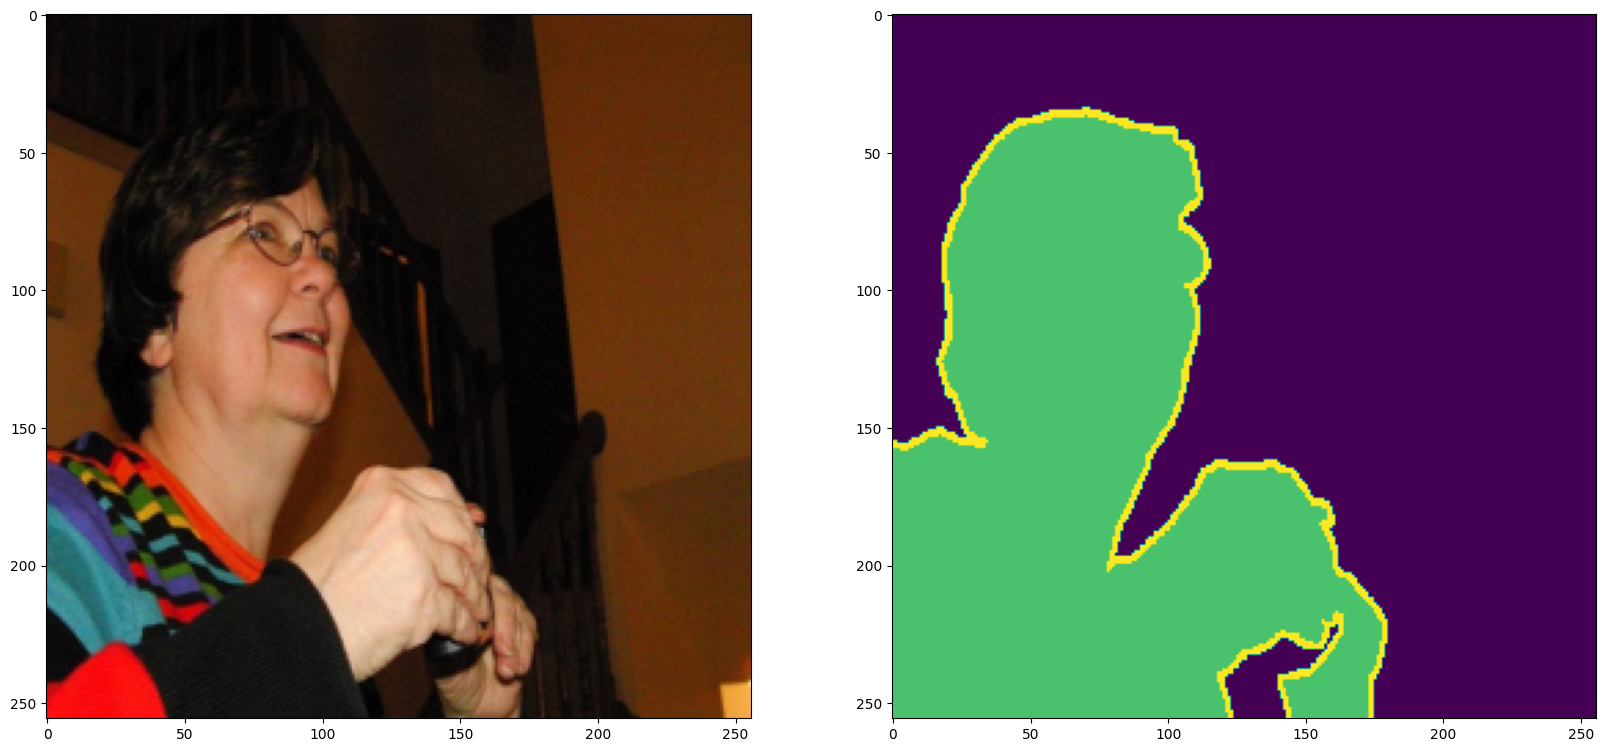

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.93it/s]


Epoch: 0 - TrainLoss: 3.3032287657260895 - ValidLoss: 5.766640206178029


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.12it/s]


Epoch: 1 - TrainLoss: 2.6791110237439475 - ValidLoss: 4.619726479053497


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.13it/s]


Epoch: 2 - TrainLoss: 2.2536193430423737 - ValidLoss: 4.254882365465164


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.73it/s]


Epoch: 3 - TrainLoss: 1.9447389443715413 - ValidLoss: 3.7964788178602853


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.88it/s]


Epoch: 4 - TrainLoss: 1.7559417883555095 - ValidLoss: 3.1597607930501304


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.30it/s]


Epoch: 5 - TrainLoss: 1.678039421637853 - ValidLoss: 4.240744074185689


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.67it/s]


Epoch: 6 - TrainLoss: 1.611109346151352 - ValidLoss: 3.0012579460938773


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.18it/s]


Epoch: 7 - TrainLoss: 1.5734329869349797 - ValidLoss: 2.4865255802869797


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.97it/s]


Epoch: 8 - TrainLoss: 1.5532363255818684 - ValidLoss: 2.703883190949758


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.71it/s]


Epoch: 9 - TrainLoss: 1.5347740302483242 - ValidLoss: 2.6254472136497498


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.62it/s]


Epoch: 10 - TrainLoss: 1.5210971335570018 - ValidLoss: 2.6321257948875427


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.10it/s]


Epoch: 11 - TrainLoss: 1.4951262474060059 - ValidLoss: 2.9144275188446045


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.00it/s]


Epoch: 12 - TrainLoss: 1.488553489247958 - ValidLoss: 2.7739144464333854


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.11it/s]


Epoch: 13 - TrainLoss: 1.4891995638608932 - ValidLoss: 3.2259034464756646


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.78it/s]


Epoch: 14 - TrainLoss: 1.481735606988271 - ValidLoss: 3.3155091454585395


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.01it/s]


Epoch: 15 - TrainLoss: 1.4527967671553295 - ValidLoss: 2.4005246063073478


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.01it/s]


Epoch: 16 - TrainLoss: 1.4483121285835903 - ValidLoss: 2.6994784275690713


100%|██████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.64it/s]


Epoch: 17 - TrainLoss: 1.4440868347883224 - ValidLoss: 3.3551510820786157


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.11it/s]


Epoch: 18 - TrainLoss: 1.4122678289810817 - ValidLoss: 2.6077725986639657


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.88it/s]


Epoch: 19 - TrainLoss: 1.404435470700264 - ValidLoss: 2.845449830094973


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.13it/s]


Epoch: 20 - TrainLoss: 1.3735292330384254 - ValidLoss: 1.9384515509009361


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.08it/s]


Epoch: 21 - TrainLoss: 1.372419203321139 - ValidLoss: 2.605354274312655


100%|██████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.95it/s]


Epoch: 22 - TrainLoss: 1.372928964595 - ValidLoss: 2.996508374810219


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.16it/s]


Epoch: 23 - TrainLoss: 1.3563321828842163 - ValidLoss: 2.501659075419108


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.93it/s]


Epoch: 24 - TrainLoss: 1.3206907163063686 - ValidLoss: 2.1275130858023963


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.96it/s]


Epoch: 25 - TrainLoss: 1.308312565088272 - ValidLoss: 2.607553154230118


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.52it/s]


Epoch: 26 - TrainLoss: 1.312250609199206 - ValidLoss: 3.531961664557457


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.97it/s]


Epoch: 27 - TrainLoss: 1.2639224231243134 - ValidLoss: 2.1088726818561554


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  5.93it/s]


Epoch: 28 - TrainLoss: 1.2646105488141377 - ValidLoss: 2.203965892394384


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.71it/s]


Epoch: 29 - TrainLoss: 1.261698340376218 - ValidLoss: 2.8795615335305533


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.11it/s]


Epoch: 30 - TrainLoss: 1.2679334531227748 - ValidLoss: 2.5564298381408057


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.35it/s]


Epoch: 31 - TrainLoss: 1.2248125423987706 - ValidLoss: 3.1556590497493744


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.42it/s]


Epoch: 32 - TrainLoss: 1.190632976591587 - ValidLoss: 2.2956353028615317


100%|██████████████████████████████████████████████████████| 47/47 [00:10<00:00,  4.52it/s]


Epoch: 33 - TrainLoss: 1.1764040018121402 - ValidLoss: 2.0758194476366043


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.09it/s]


Epoch: 34 - TrainLoss: 1.1569774722059567 - ValidLoss: 2.13986337184906


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.83it/s]


Epoch: 35 - TrainLoss: 1.1315323760112126 - ValidLoss: 2.3834747076034546


100%|██████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.64it/s]


Epoch: 36 - TrainLoss: 1.124053567647934 - ValidLoss: 2.3993820945421853


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.24it/s]


Epoch: 37 - TrainLoss: 1.0943746616442998 - ValidLoss: 2.3190901776154837


100%|██████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.84it/s]


Epoch: 38 - TrainLoss: 1.0897748842835426 - ValidLoss: 2.762372136116028


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.07it/s]


Epoch: 39 - TrainLoss: 1.0554774329066277 - ValidLoss: 1.9428416068355243


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.57it/s]


Epoch: 40 - TrainLoss: 1.0668675179282825 - ValidLoss: 2.0991022686163583


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.60it/s]


Epoch: 41 - TrainLoss: 1.047589436173439 - ValidLoss: 3.402189696828524


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.62it/s]


Epoch: 42 - TrainLoss: 1.0202029943466187 - ValidLoss: 1.7268184050917625


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.59it/s]


Epoch: 43 - TrainLoss: 1.0032658353447914 - ValidLoss: 2.3526810506979623


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.44it/s]


Epoch: 44 - TrainLoss: 0.9481063783168793 - ValidLoss: 1.7406286969780922


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.62it/s]


Epoch: 45 - TrainLoss: 0.9302778169512749 - ValidLoss: 2.2627564569314322


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.63it/s]


Epoch: 46 - TrainLoss: 0.9170141816139221 - ValidLoss: 1.6307464490334194


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.61it/s]


Epoch: 47 - TrainLoss: 0.9038580556710561 - ValidLoss: 1.8244360436995823


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.67it/s]


Epoch: 48 - TrainLoss: 0.8920856987436613 - ValidLoss: 1.6702137639125187


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.63it/s]


Epoch: 49 - TrainLoss: 0.8772723947962126 - ValidLoss: 1.7697120880087216


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.57it/s]


Epoch: 50 - TrainLoss: 0.8473926658431689 - ValidLoss: 1.7375459695855777


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.71it/s]


Epoch: 51 - TrainLoss: 0.8444711888829867 - ValidLoss: 1.5304365307092667


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.49it/s]


Epoch: 52 - TrainLoss: 0.8233299652735392 - ValidLoss: 1.8622314954797428


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.46it/s]


Epoch: 53 - TrainLoss: 0.8155106181899706 - ValidLoss: 1.6695079232255619


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.69it/s]


Epoch: 54 - TrainLoss: 0.7880396495262781 - ValidLoss: 1.4268058811624844


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.67it/s]


Epoch: 55 - TrainLoss: 0.7640064557393392 - ValidLoss: 1.3310095146298409


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.58it/s]


Epoch: 56 - TrainLoss: 0.7495661427577337 - ValidLoss: 1.3763230393330257


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.53it/s]


Epoch: 57 - TrainLoss: 0.713053767879804 - ValidLoss: 1.6665910631418228


100%|██████████████████████████████████████████████████████| 47/47 [00:06<00:00,  6.76it/s]


Epoch: 58 - TrainLoss: 0.7273339902361234 - ValidLoss: 2.2228483855724335


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.59it/s]


Epoch: 59 - TrainLoss: 0.7197653725743294 - ValidLoss: 1.6770419875780742


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.62it/s]


Epoch: 60 - TrainLoss: 0.6735878884792328 - ValidLoss: 1.4148912156621616


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.56it/s]


Epoch: 61 - TrainLoss: 0.695908839503924 - ValidLoss: 1.7338784461220105


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.63it/s]


Epoch: 62 - TrainLoss: 0.6553439473112425 - ValidLoss: 1.418250933289528


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.65it/s]


Epoch: 63 - TrainLoss: 0.6456284746527672 - ValidLoss: 1.3588328510522842


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.60it/s]


Epoch: 64 - TrainLoss: 0.6146463205416998 - ValidLoss: 1.226359615723292


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.56it/s]


Epoch: 65 - TrainLoss: 0.6064667167762915 - ValidLoss: 1.2324774463971455


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.48it/s]


Epoch: 66 - TrainLoss: 0.6088400147855282 - ValidLoss: 1.8432623917857807


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.58it/s]


Epoch: 67 - TrainLoss: 0.6106316819787025 - ValidLoss: 1.2446801910797756


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.37it/s]


Epoch: 68 - TrainLoss: 0.5964594930410385 - ValidLoss: 1.3691572447617848


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.58it/s]


Epoch: 69 - TrainLoss: 0.5709717323382696 - ValidLoss: 0.8371506333351135


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.59it/s]


Epoch: 70 - TrainLoss: 0.5497401021420956 - ValidLoss: 1.2679637124141057


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.68it/s]


Epoch: 71 - TrainLoss: 0.5434170129398505 - ValidLoss: 1.4245692988236744


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.55it/s]


Epoch: 72 - TrainLoss: 0.5217587302128474 - ValidLoss: 0.8933058219651381


100%|██████████████████████████████████████████████████████| 47/47 [00:06<00:00,  6.73it/s]


Epoch: 73 - TrainLoss: 0.5238046161830425 - ValidLoss: 1.0929926112294197


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.37it/s]


Epoch: 74 - TrainLoss: 0.513223355015119 - ValidLoss: 1.0359784960746765


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.61it/s]


Epoch: 75 - TrainLoss: 0.4782872684299946 - ValidLoss: 0.8713368078072866


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.39it/s]


Epoch: 76 - TrainLoss: 0.49188579246401787 - ValidLoss: 0.976335716744264


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.41it/s]


Epoch: 77 - TrainLoss: 0.48609015842278797 - ValidLoss: 1.1763281524181366


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.62it/s]


Epoch: 78 - TrainLoss: 0.4827126016219457 - ValidLoss: 1.680547962586085


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.66it/s]


Epoch: 79 - TrainLoss: 0.4868055147429307 - ValidLoss: 1.0241534759600956


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.42it/s]


Epoch: 80 - TrainLoss: 0.45791415497660637 - ValidLoss: 1.232657787700494


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.67it/s]


Epoch: 81 - TrainLoss: 0.45189836124579114 - ValidLoss: 1.0922571221987407


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.57it/s]


Epoch: 82 - TrainLoss: 0.45892703036467236 - ValidLoss: 1.102782517671585


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.61it/s]


Epoch: 83 - TrainLoss: 0.4406726124385993 - ValidLoss: 0.6608374193310738


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.48it/s]


Epoch: 84 - TrainLoss: 0.43604231998324394 - ValidLoss: 0.8500237340728442


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.67it/s]


Epoch: 85 - TrainLoss: 0.4379627580444018 - ValidLoss: 1.0435997545719147


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.69it/s]


Epoch: 86 - TrainLoss: 0.4303110142548879 - ValidLoss: 1.034682956834634


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.51it/s]


Epoch: 87 - TrainLoss: 0.431197722752889 - ValidLoss: 0.8552348390221596


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.55it/s]


Epoch: 88 - TrainLoss: 0.41365375618139905 - ValidLoss: 0.7915198480089506


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.66it/s]


Epoch: 89 - TrainLoss: 0.4141192014018695 - ValidLoss: 1.10782623787721


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.44it/s]


Epoch: 90 - TrainLoss: 0.42620616406202316 - ValidLoss: 1.1898169815540314


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.41it/s]


Epoch: 91 - TrainLoss: 0.40657717113693553 - ValidLoss: 0.8310405649244785


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.58it/s]


Epoch: 92 - TrainLoss: 0.4258989865581195 - ValidLoss: 1.8937978769342105


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.62it/s]


Epoch: 93 - TrainLoss: 0.42215341826279956 - ValidLoss: 0.7750581304232279


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.69it/s]


Epoch: 94 - TrainLoss: 0.4110446038345496 - ValidLoss: 0.8564220567544302


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.58it/s]


Epoch: 95 - TrainLoss: 0.4220581104358037 - ValidLoss: 1.5106818626324336


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.71it/s]


Epoch: 96 - TrainLoss: 0.4086911790072918 - ValidLoss: 0.8804408920307955


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.57it/s]


Epoch: 97 - TrainLoss: 0.4261757532755534 - ValidLoss: 1.131724903980891


100%|██████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.58it/s]


Epoch: 98 - TrainLoss: 0.4072781167924404 - ValidLoss: 0.8454780243337154


100%|██████████████████████████████████████████████████████| 47/47 [00:06<00:00,  6.83it/s]

Epoch: 99 - TrainLoss: 0.4106423445045948 - ValidLoss: 0.9391833655536175


<All keys matched successfully>

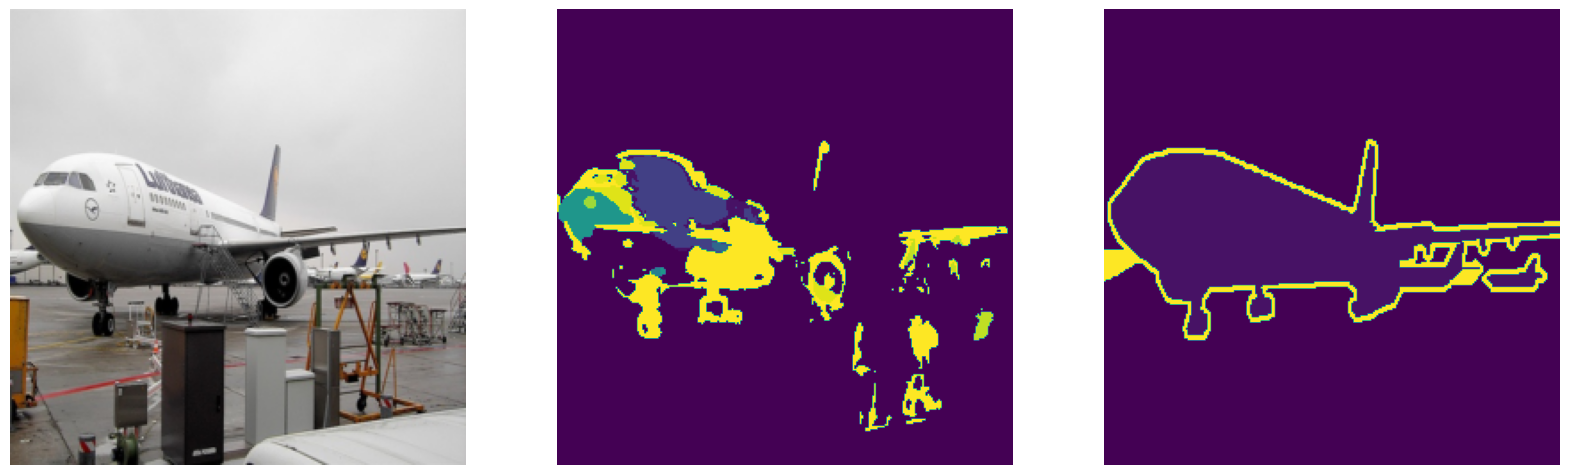

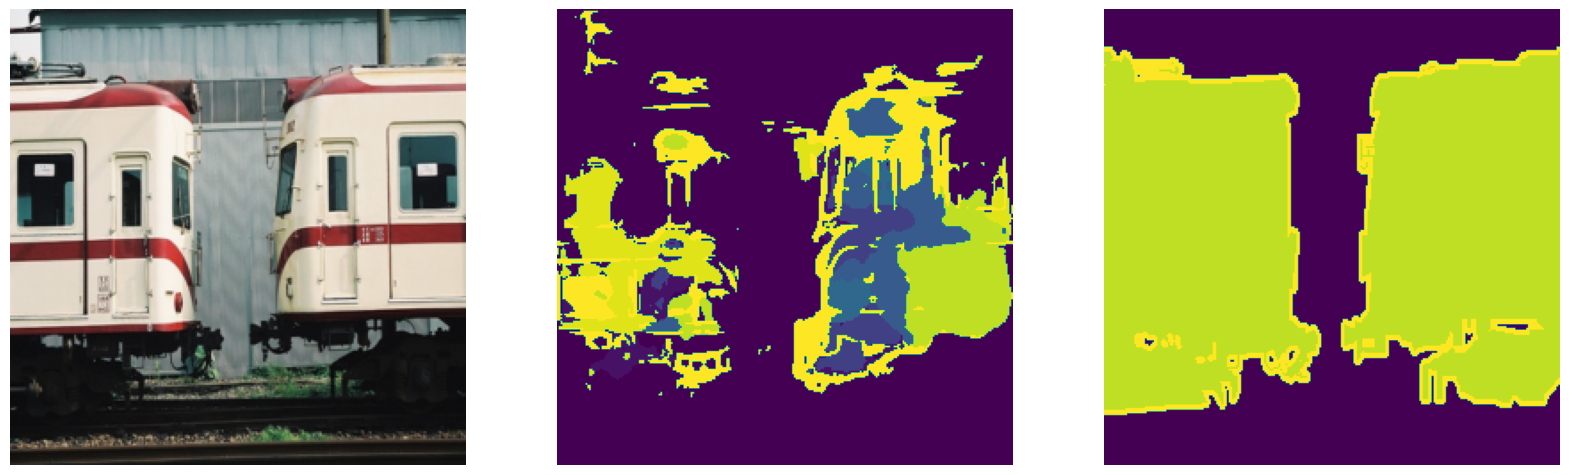

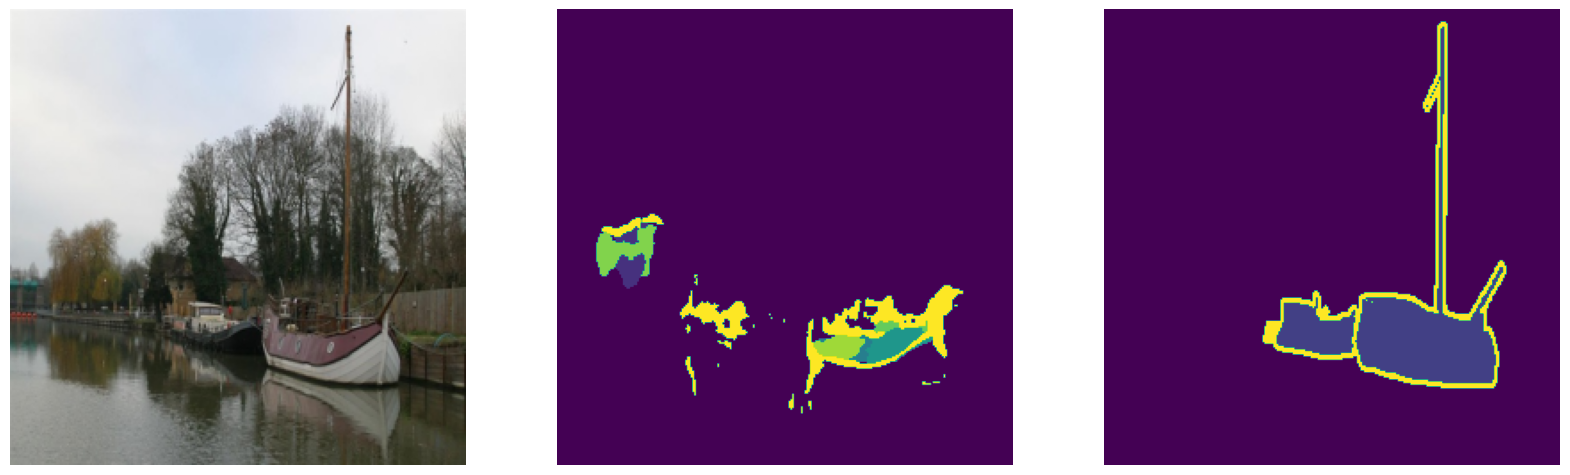

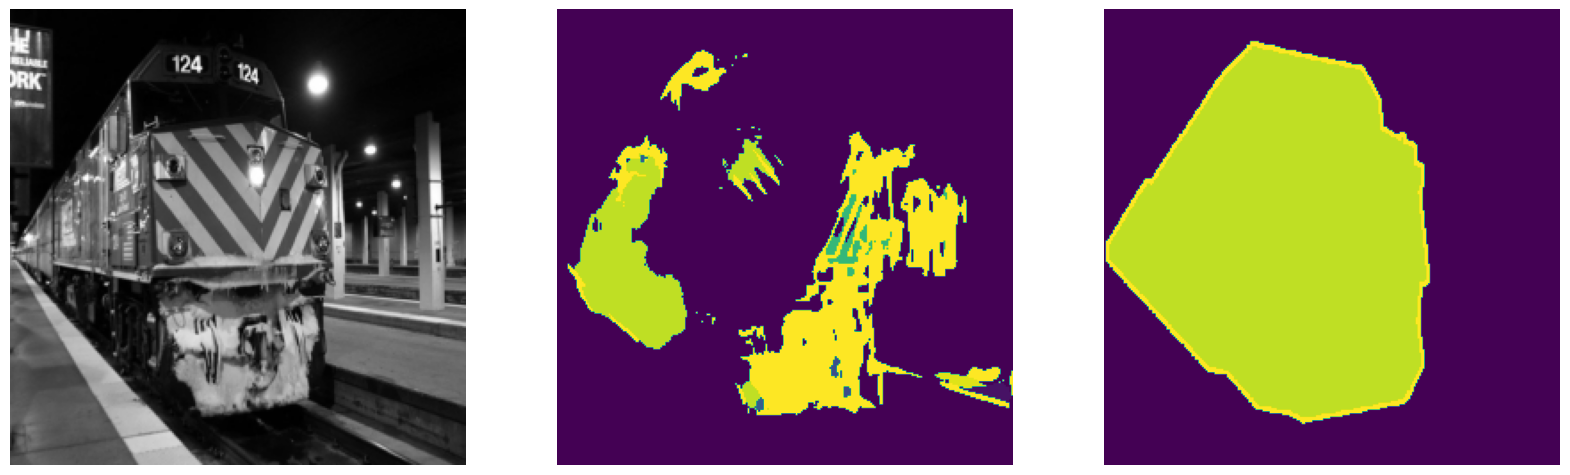

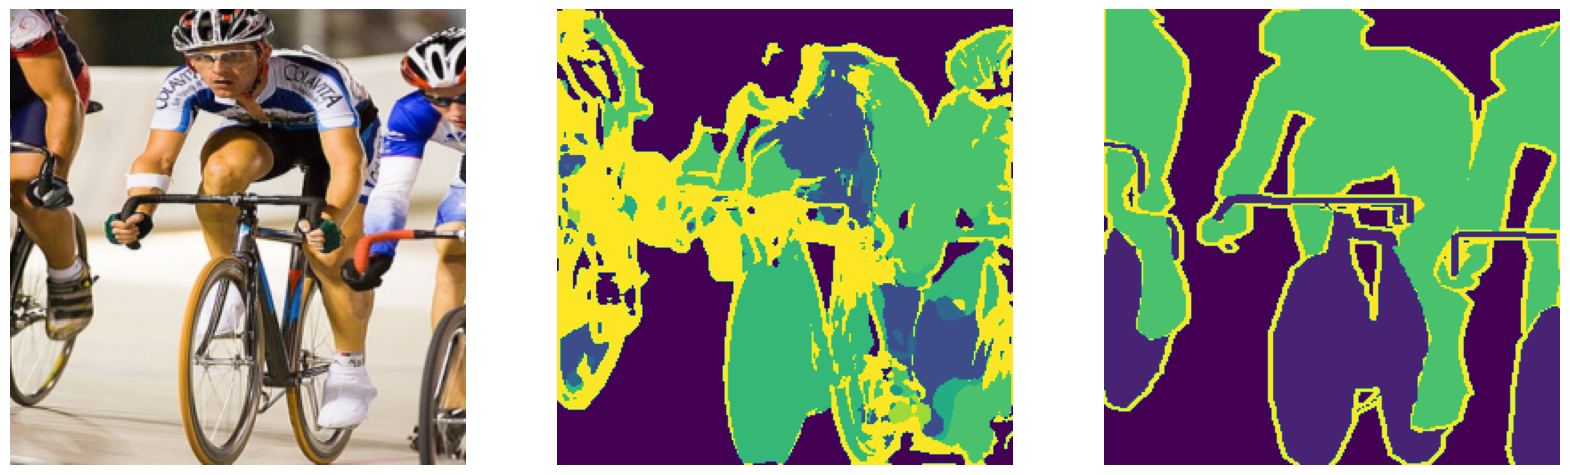

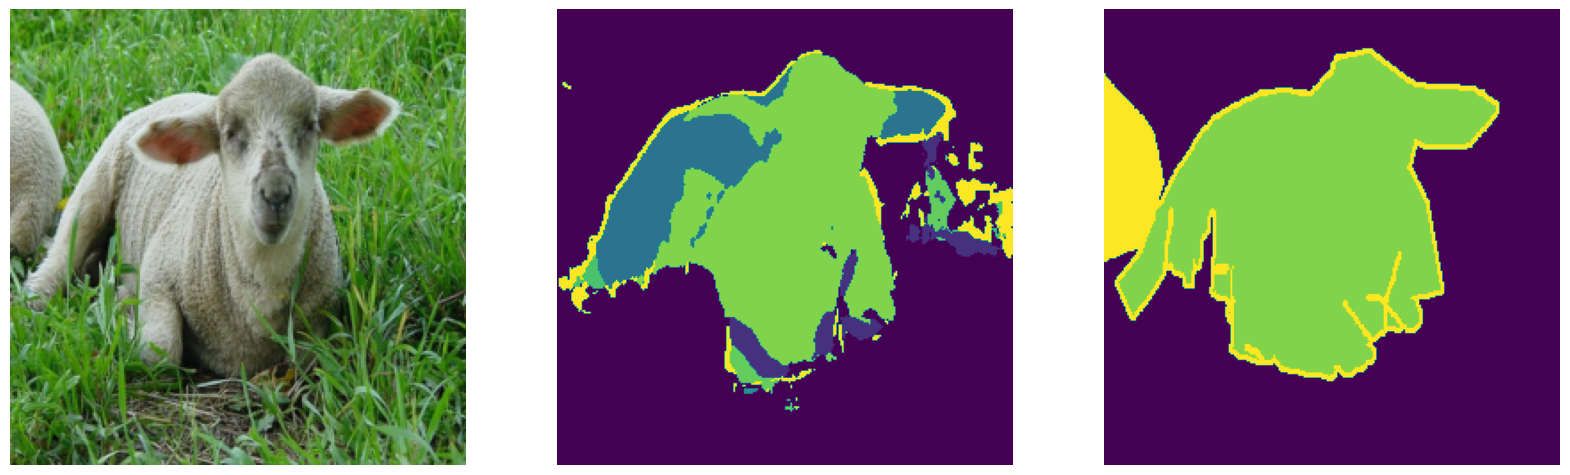

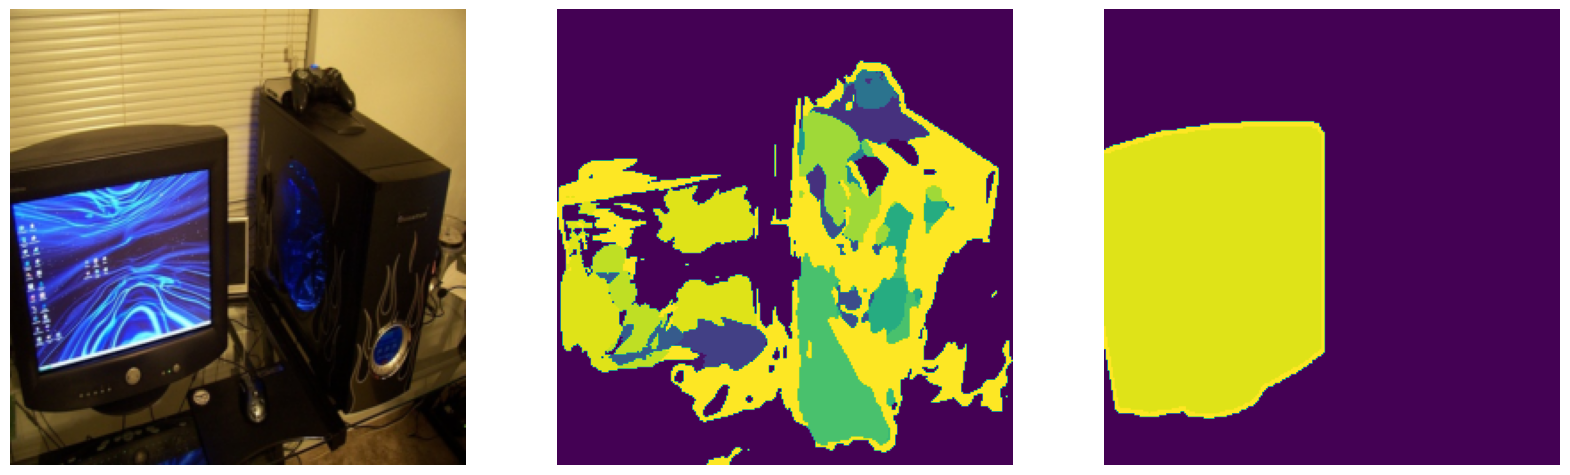

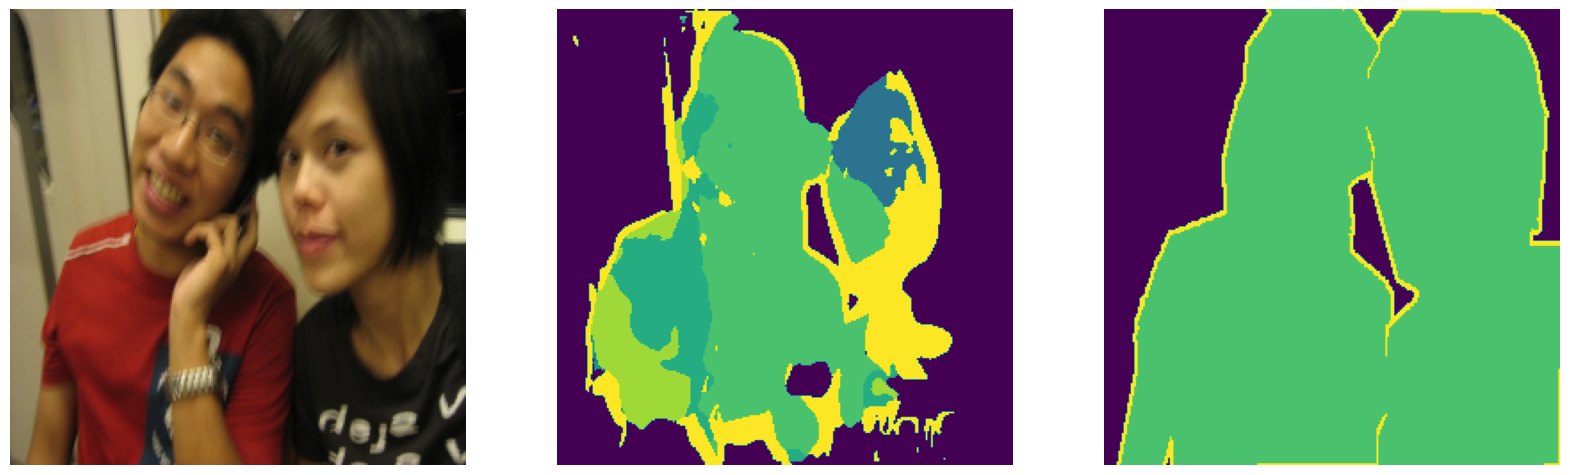

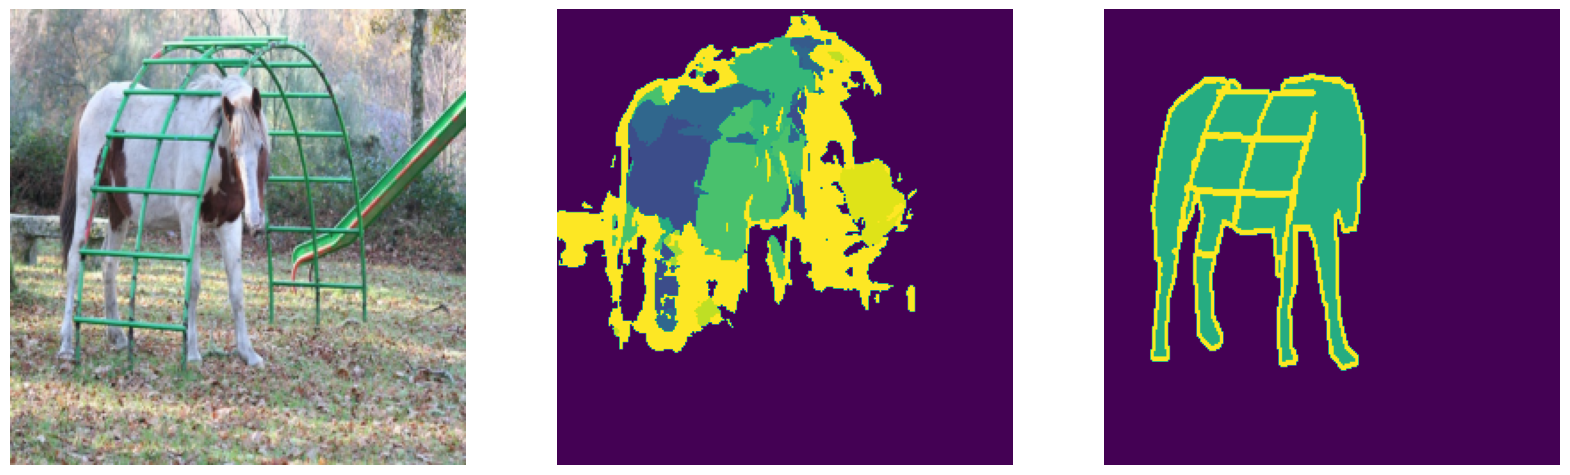

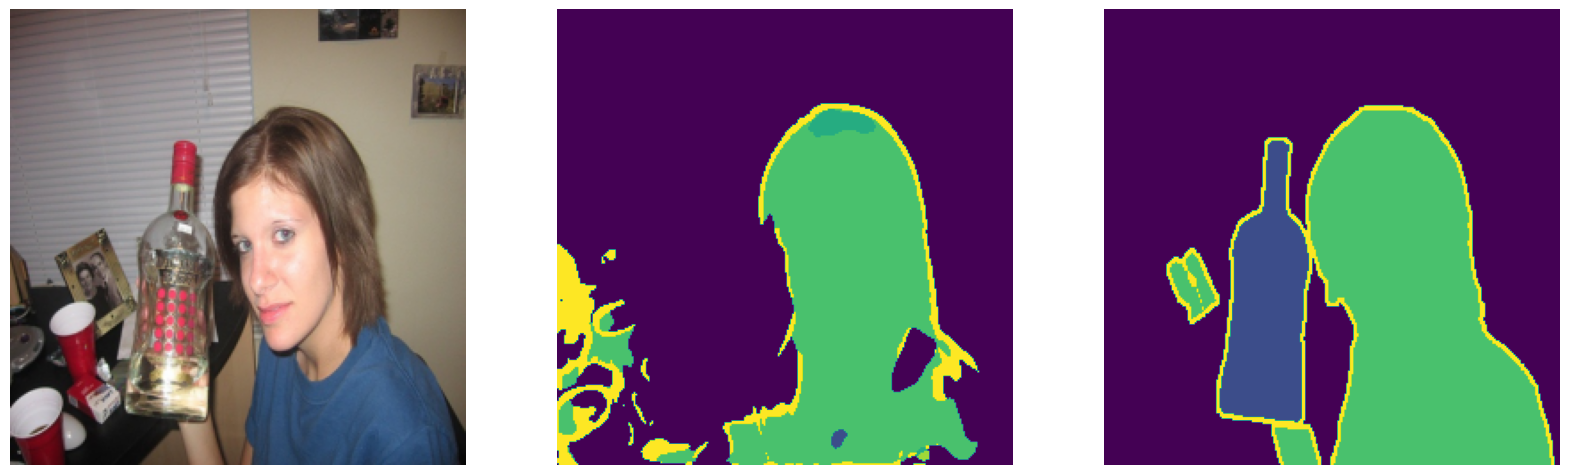

In [12]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')